In [ ]:
# @title **[1/4] Run project imports** { run: "auto", vertical-output: true, display-mode: "form" }

import copy
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as nptp
import random
import typing as tp
import warnings

from dataclasses import dataclass, field
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from statsmodels.tsa.stattools import acf, adfuller
from sys import setrecursionlimit
from threading import stack_size

%config InlineBackend.figure_format = 'retina'

def seed_everything(recursionlimit: int = 10 ** 9,
                    size: int = 2 ** 26,
                    seed: int = 239) -> None:
    setrecursionlimit(recursionlimit)
    stack_size(size)
    random.seed(seed)
    np.random.seed(seed)

seed_everything()

# **Time series (AutoRegression models)**

In [ ]:
# @title **[2/4] Initialize time series generator**


@dataclass()
class TimeSeriesGenerator:
    def __init__(self,
                 coeffs: tp.Sequence[float],
                 stddev: tp.Optional[float],
                 length: int = 1000,
                 init_min: float  = -10,
                 init_max: float = 10) -> None:
        window = len(coeffs) - 1
        scale, offset = init_max - init_min, init_min
        self.raw_series = np.random.rand(length) * scale + offset

        bias = coeffs[0]
        coeffs = coeffs[:0:-1]
        for i in range(window, length):
            self.raw_series[i] = np.dot(self.raw_series[i - window: i], coeffs) + bias

        if stddev is None:
            stddev = np.sqrt(length)
        stddev = tp.cast(float, stddev)
        self.noise = self._get_gaussian_noise(self.raw_series, stddev)
        self.__series = self.raw_series + self.noise
        self.__series = self.__series[int(0.05 * self.__series.shape[0]):]  # cut first 5% of data

        if not self.is_stationary(self.__series):
            warnings.warn(f'Coefficients {coeffs} result in non-stationary AR model')

    @property
    def series(self) -> nptp.NDArray:
        return copy.deepcopy(self.__series)

    def get_lagged(self, timesteps: int) -> nptp.NDArray:
        lagged = []
        for i in range(self.__series.shape[0] - timesteps + 1):
            lagged.append(self.__series[i:i + timesteps])
        return copy.deepcopy(np.array(lagged))

    @staticmethod
    def is_stationary(series: nptp.NDArray, alpha: float = 0.05) -> bool:
        p_value = float(adfuller(series)[1])
        return p_value < alpha

    @staticmethod
    def _get_diff(series: nptp.NDArray, eps: float = 1e-6) -> nptp.NDArray:
        diff = np.diff(series)
        return series if np.max(np.abs(diff)) < eps else series - np.mean(diff)

    @staticmethod
    def _get_gaussian_noise(series: nptp.NDArray,
                            stddev: float) -> nptp.NDArray:
        return np.random.normal(0, stddev, size=series.shape)

    def plot(self, last_k: tp.Optional[int] = None) -> None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        prefix = ''
        if last_k is None:
            ax.plot(self.series)
        else:
            ax.plot(self.series[-last_k:])
            prefix = f'Last {last_k} '
        ax.set(xlabel='time, t',
                ylabel='values',
                title=f'{prefix}TS values')
        ax.grid()
        plt.show()

In [ ]:
AR3_COEFFS = [0.05, 1.1, -0.8, 0.6]
TRAIN_RATIO = 0.8
TIMESTEPS = 4
STDDEV = 0.05

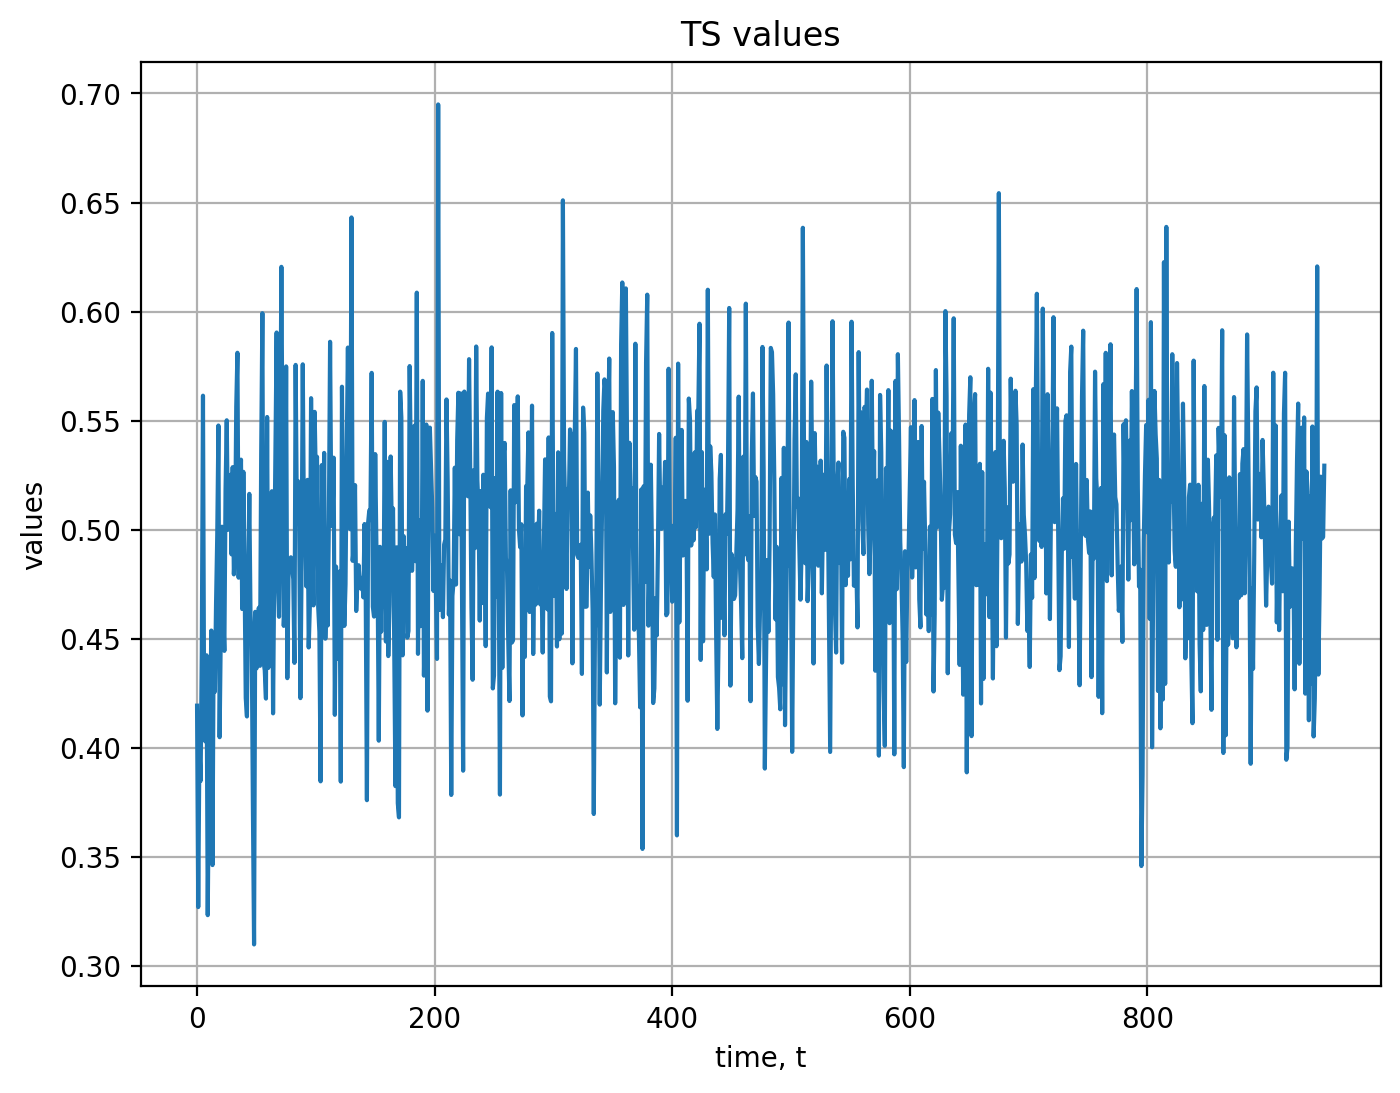

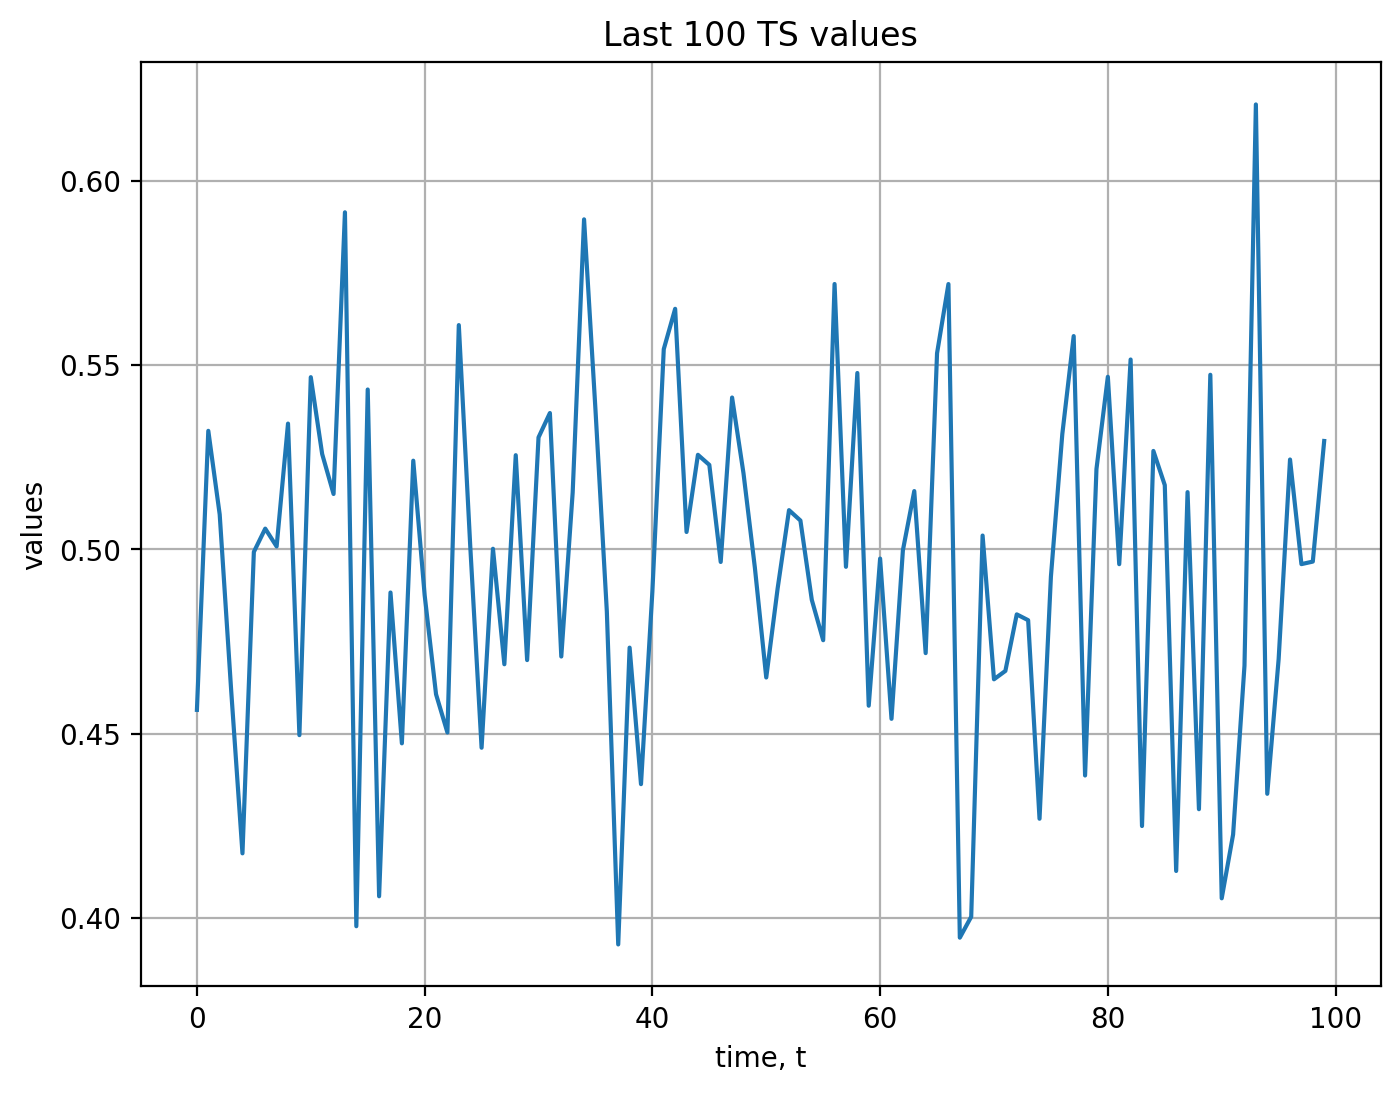

In [ ]:
ts = TimeSeriesGenerator(AR3_COEFFS, stddev=STDDEV)
ts.plot()
ts.plot(100)

In [ ]:
# @title **[3/4] Time series preprocessing, batch splitting** { vertical-output: true, display-mode: "form" }


lagged_series = ts.get_lagged(timesteps=TIMESTEPS)
test_index = int(TRAIN_RATIO * lagged_series.shape[0])

train_ts, test_ts = lagged_series[:test_index], lagged_series[test_index:]
lags_train, value_train = train_ts[:, :(TIMESTEPS - 1)], train_ts[:, TIMESTEPS - 1]
lags_test, value_test = test_ts[:, :(TIMESTEPS - 1)], test_ts[:, TIMESTEPS - 1]

print(f'Train shape\n\tlags: {lags_train.shape}\n\tlabel: {value_train.shape}\n' +
      f'Test shape\n\tlags: {lags_test.shape}\n\tlabel: {value_test.shape}')

Train shape
	lags: (757, 3)
	label: (757,)
Test shape
	lags: (190, 3)
	label: (190,)


In [ ]:
# @title **[4/4] Pipeline evaluation and plotting** { display-mode: "form" }


def plot_results(value_hat: nptp.NDArray,
                 value: nptp.NDArray,
                 last_k_percent: tp.Optional[float] = None) -> None:
    with plt.ion():
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        if last_k_percent is None:
            last_k_percent = 1.0
        assert 0.0 < last_k_percent <= 1.0
        last_k = int(last_k_percent * len(value))
        ax.plot(value[-last_k:], label=f'Actual last {last_k}', color='r', linewidth=2.0, alpha=0.6)
        ax.plot(value_hat[-last_k:], label=f'Predicted last {last_k}', color='b', linewidth=0.8)
        ax.set(xlabel='timestamp, t', ylabel='value')
        ax.legend()
        plt.show()


def evaluate_pipeline(model: tp.Any, last_k_percent: tp.Optional[float] = None):
    pipeline = make_pipeline(model)
    pipeline.fit(lags_train, value_train)

    value_test_hat = pipeline.predict(lags_test)
    value_train_hat = pipeline.predict(lags_train)
    print(value_test_hat.shape, value_test.shape)

    plot_results(value_train_hat, value_train, last_k_percent)
    plot_results(value_test_hat, value_test, last_k_percent)

    print(f'Train data\n\trmse: {np.sqrt(mse(value_train_hat, value_train)) * 100} \n' +
        f'Test data\n\trmse: {np.sqrt(mse(value_test_hat, value_test)) * 100} ')

https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel

(190,) (190,)


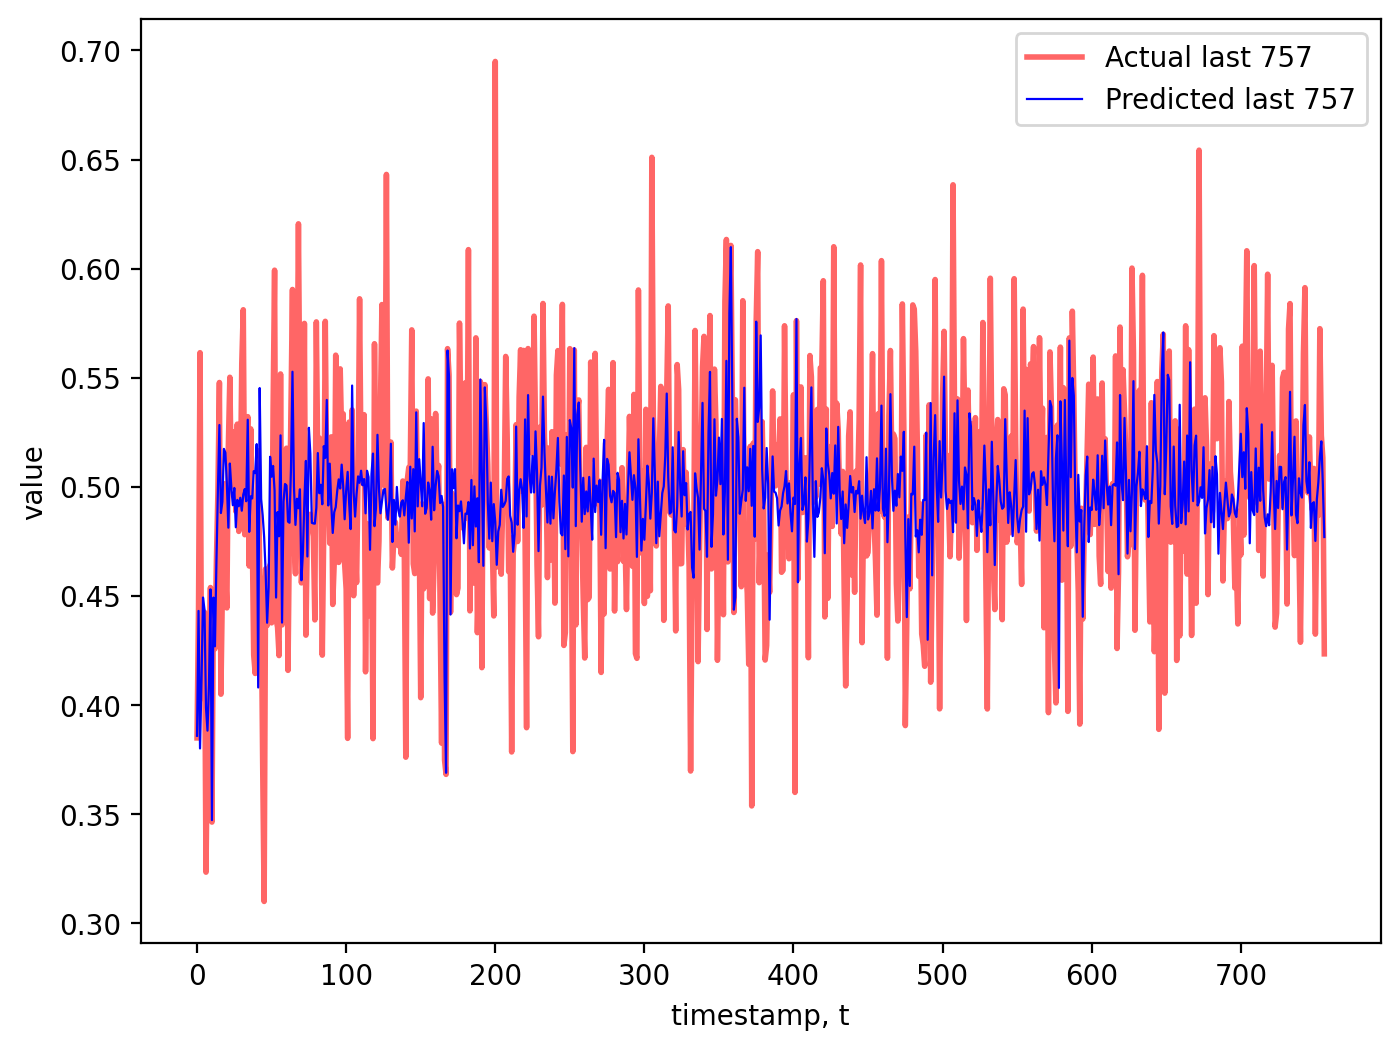

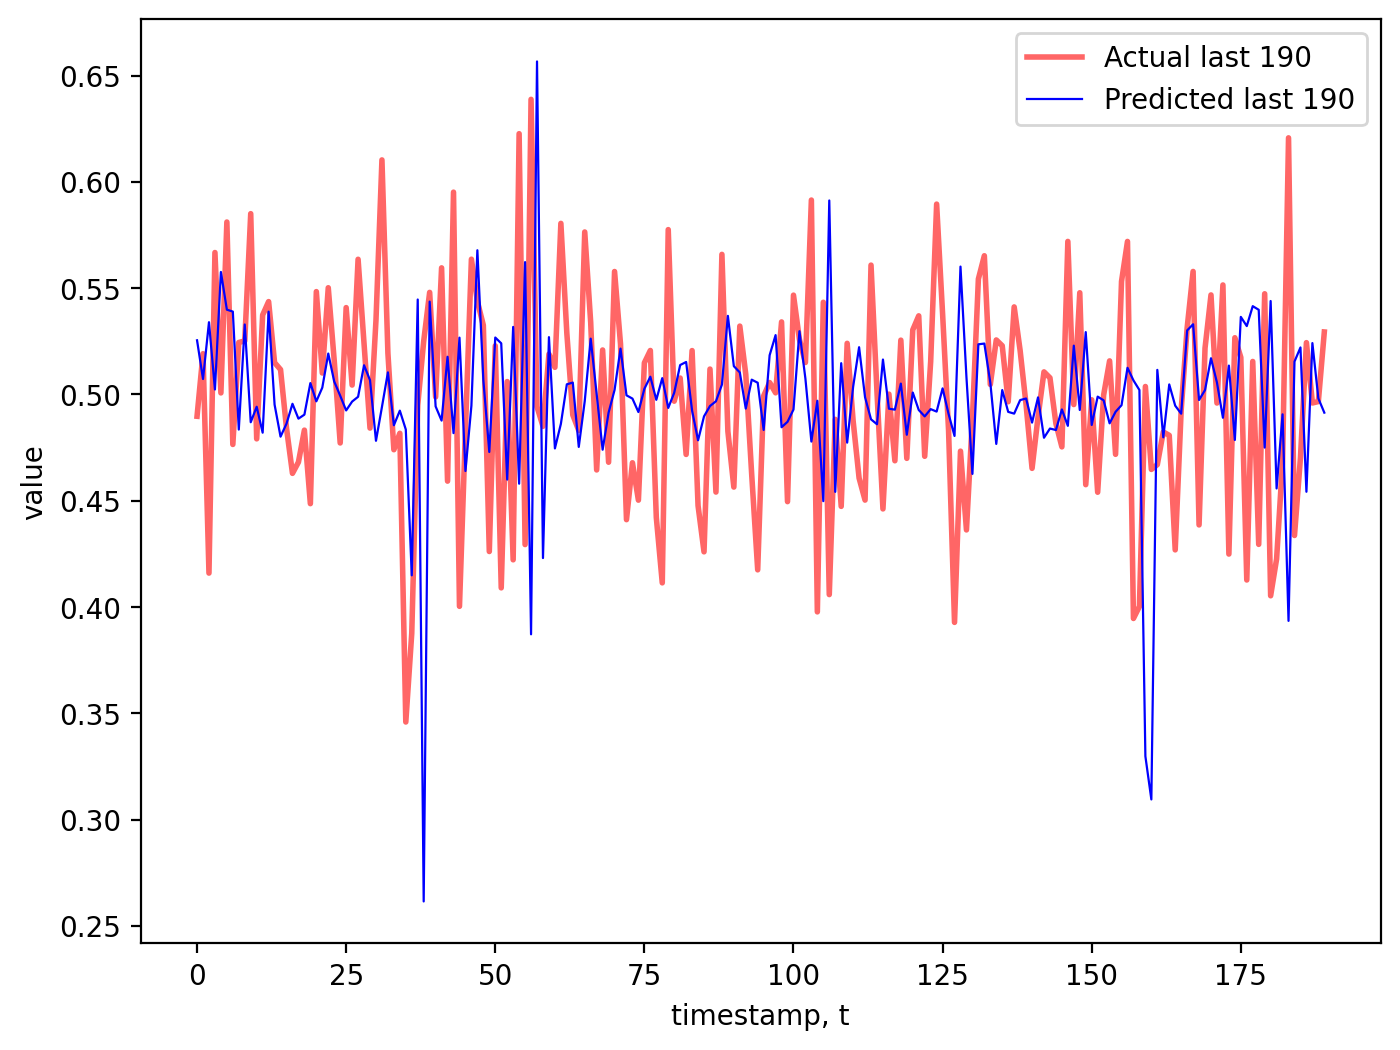

Train data
	rmse: 4.718620243135344 
Test data
	rmse: 6.73011524090337 


In [ ]:
evaluate_pipeline(SVR(kernel='rbf', C=10, epsilon=0.001))

(190,) (190,)


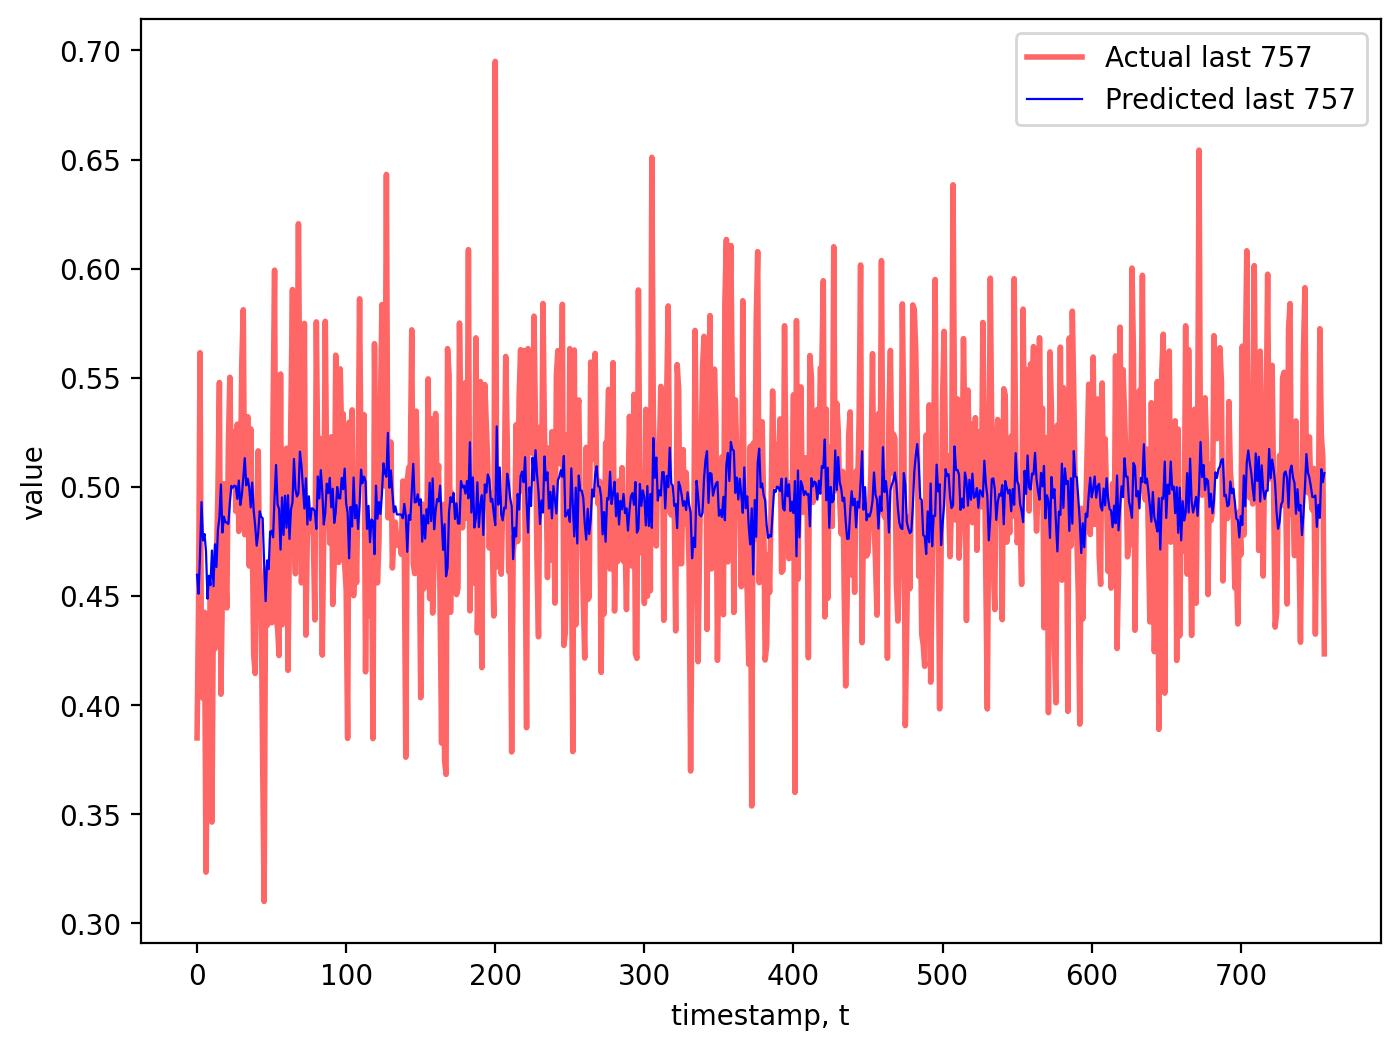

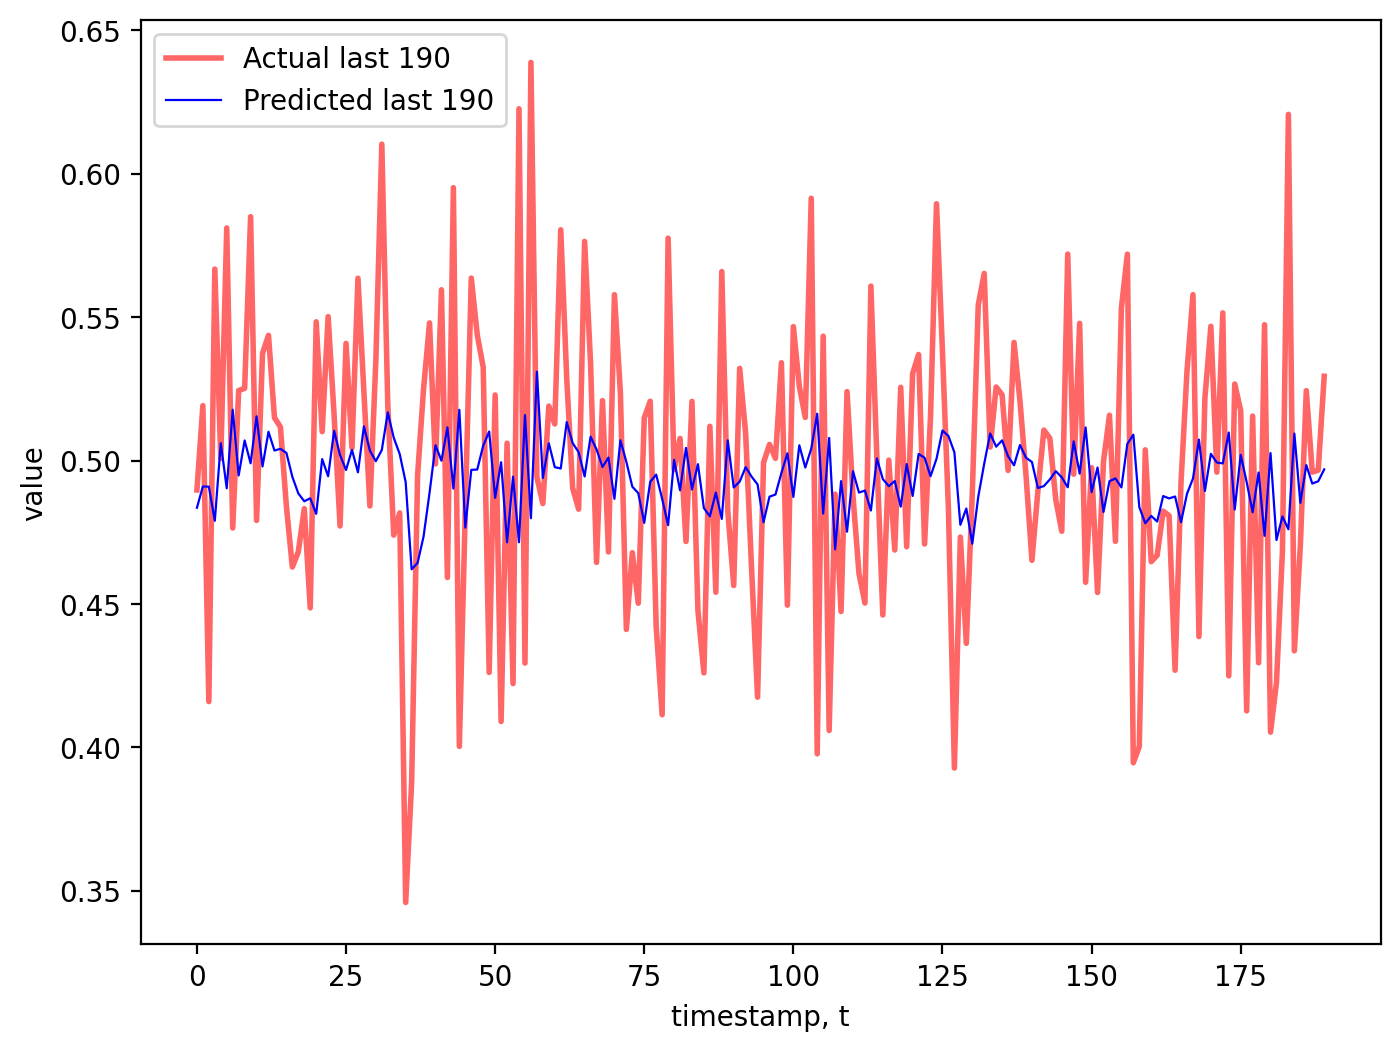

Train data
	rmse: 5.158634358626464 
Test data
	rmse: 5.329762644815281 


In [ ]:
evaluate_pipeline(SVR(kernel='linear', C=10))

(190,) (190,)


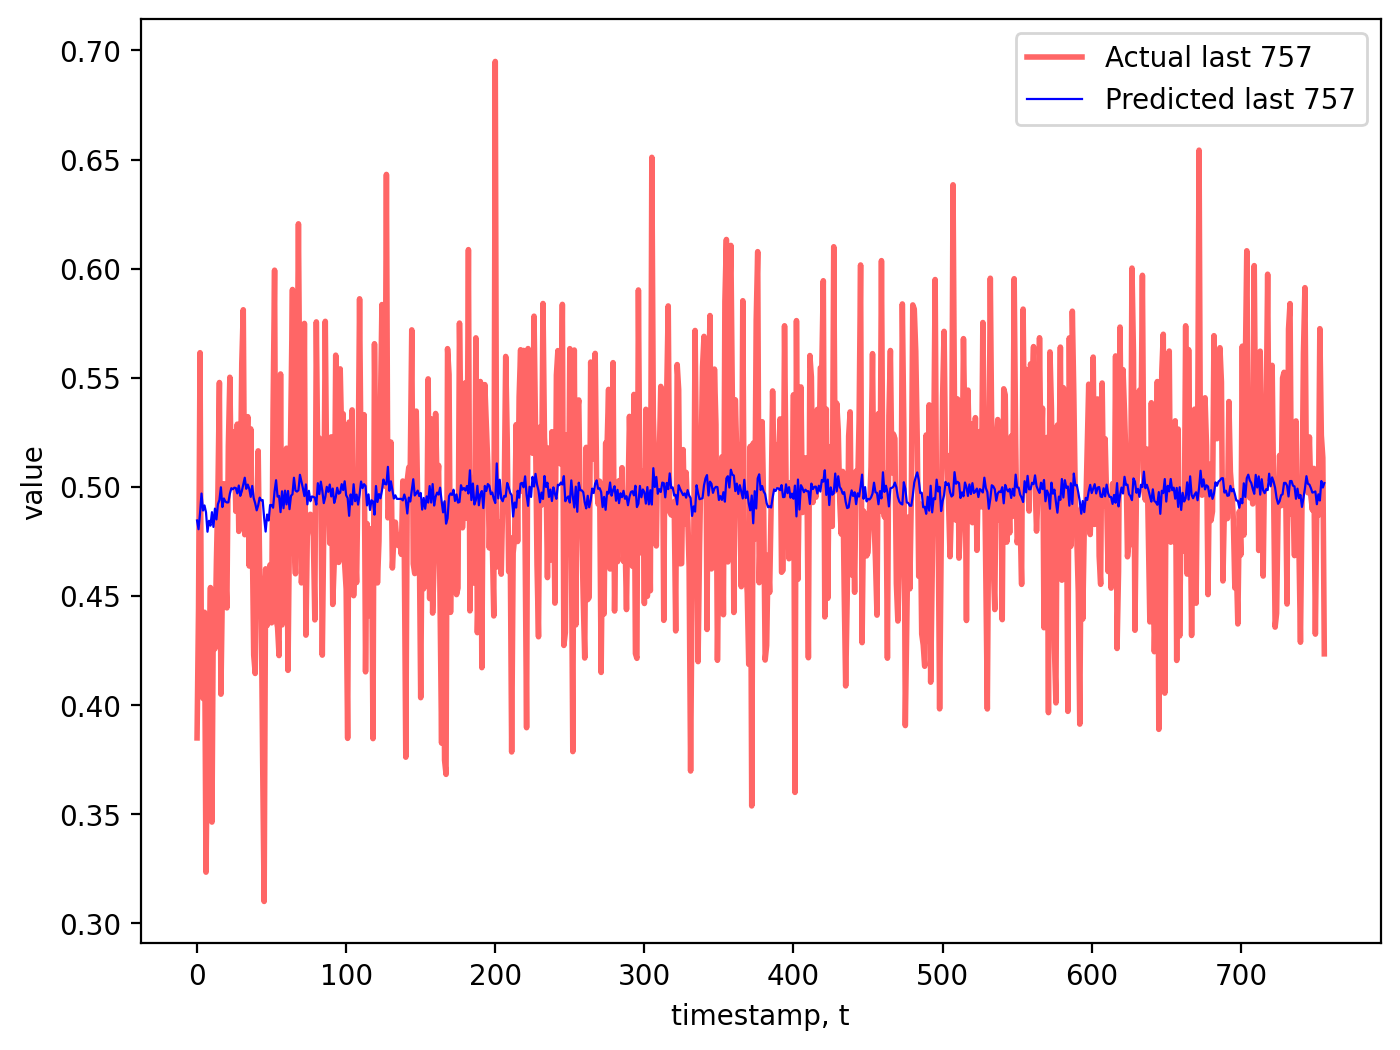

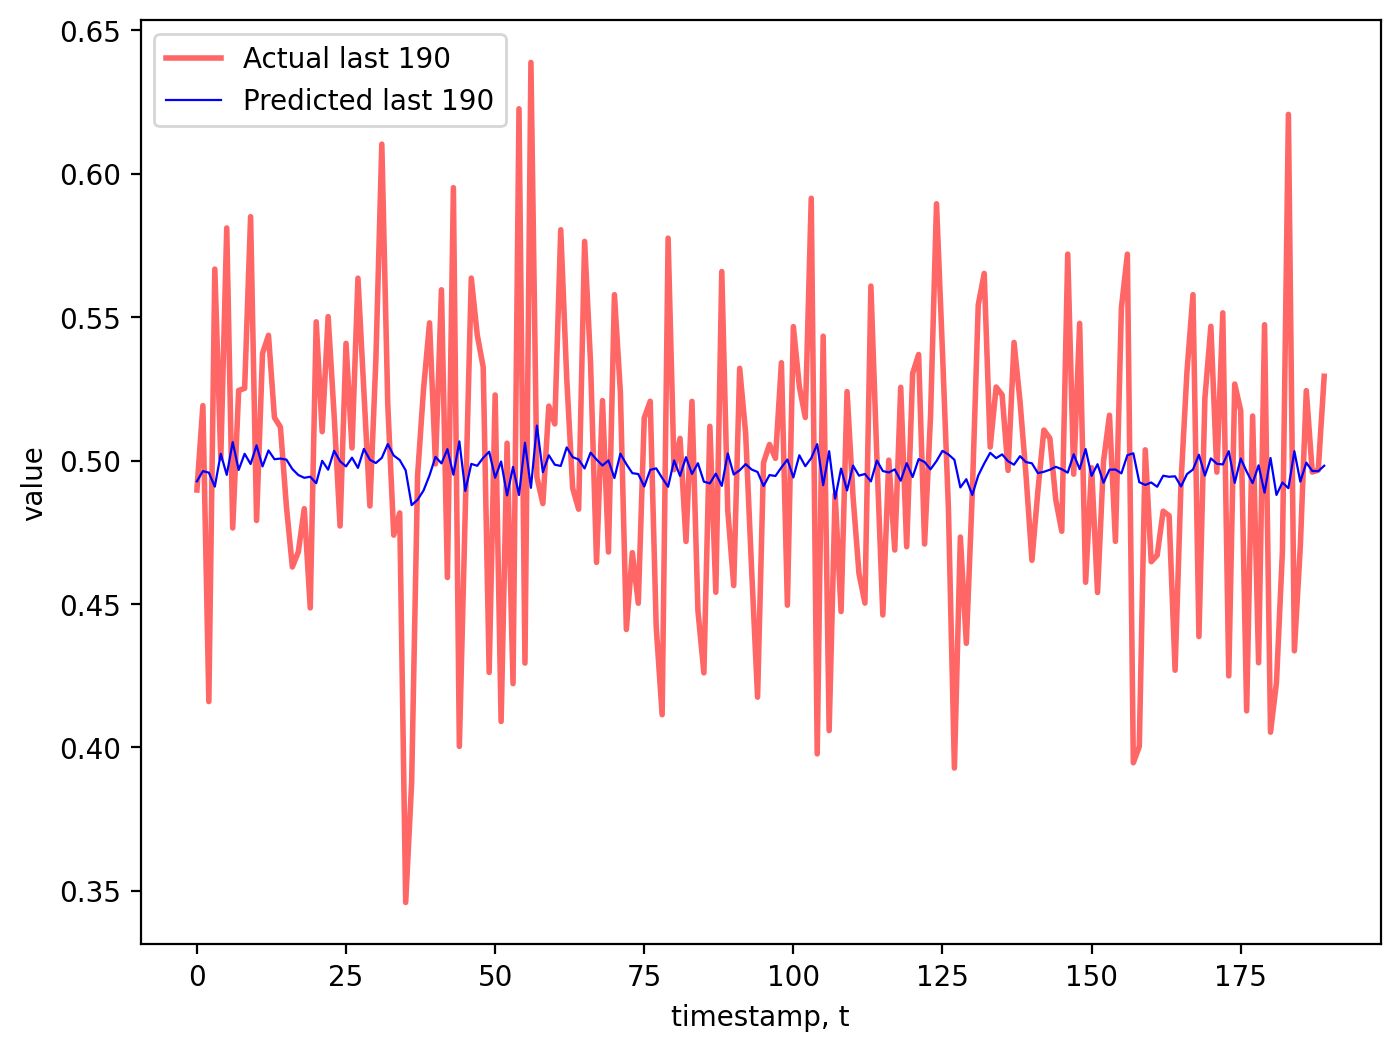

Train data
	rmse: 5.099268782311881 
Test data
	rmse: 5.139987671685824 


In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNet

evaluate_pipeline(LinearRegression())

In [ ]:
!pip install optuna

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [ ]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    naive_error = np.mean(np.abs(actual[1:] - actual[:-1]))
    return mae / naive_error

In [ ]:
from sklearn.metrics import r2_score

def objective(trial):
    # kernel = trial.suggest_categorical('kernel', ['rbf', 'linear'])
    kernel = 'rbf'
    epsilon = trial.suggest_float('epsilon', 1e-5, 1e-2, log=True)
    C = trial.suggest_float('C', 1, 1e2, log=True)
    gamma = trial.suggest_float('gamma', 1e-2, 1e2, log=True)
    _obj = SVR(kernel=kernel, C=C, gamma=gamma, epsilon=epsilon)
    _obj.fit(lags_train, value_train)
    return mean_absolute_scaled_error(value_test, _obj.predict(lags_test))

In [ ]:
import optuna

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-01-13 17:17:42,861] A new study created in memory with name: no-name-8da9c858-3fcf-4208-84be-3515e02b541e


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-13 17:17:43,524] Trial 0 finished with value: 0.789938138999627 and parameters: {'epsilon': 0.0012887675836544795, 'C': 52.117602326320814, 'gamma': 55.52048285096326}. Best is trial 0 with value: 0.789938138999627.
[I 2024-01-13 17:17:43,577] Trial 1 finished with value: 0.676912955734937 and parameters: {'epsilon': 0.004624728051889479, 'C': 65.82004751732342, 'gamma': 0.02659445467546549}. Best is trial 1 with value: 0.676912955734937.
[I 2024-01-13 17:17:43,614] Trial 2 finished with value: 0.6789248946617036 and parameters: {'epsilon': 0.008225142027382993, 'C': 15.86567568940419, 'gamma': 0.04430721259153635}. Best is trial 1 with value: 0.676912955734937.
[I 2024-01-13 17:17:44,037] Trial 3 finished with value: 0.706418385143454 and parameters: {'epsilon': 0.0005084336270667294, 'C': 66.51125210088661, 'gamma': 24.051024587561614}. Best is trial 1 with value: 0.676912955734937.
[I 2024-01-13 17:17:44,101] Trial 4 finished with value: 0.6728212704705424 and parameters:

In [ ]:
study.best_trial.params

{'epsilon': 0.00776244829474051,
 'C': 14.403333704668052,
 'gamma': 0.4171895697963322}

In [ ]:
(lags_train.shape[1] * lags_train.var()) ** -1, 1 / lags_train.shape[1]

(125.59244889186391, 0.3333333333333333)

(190,) (190,)


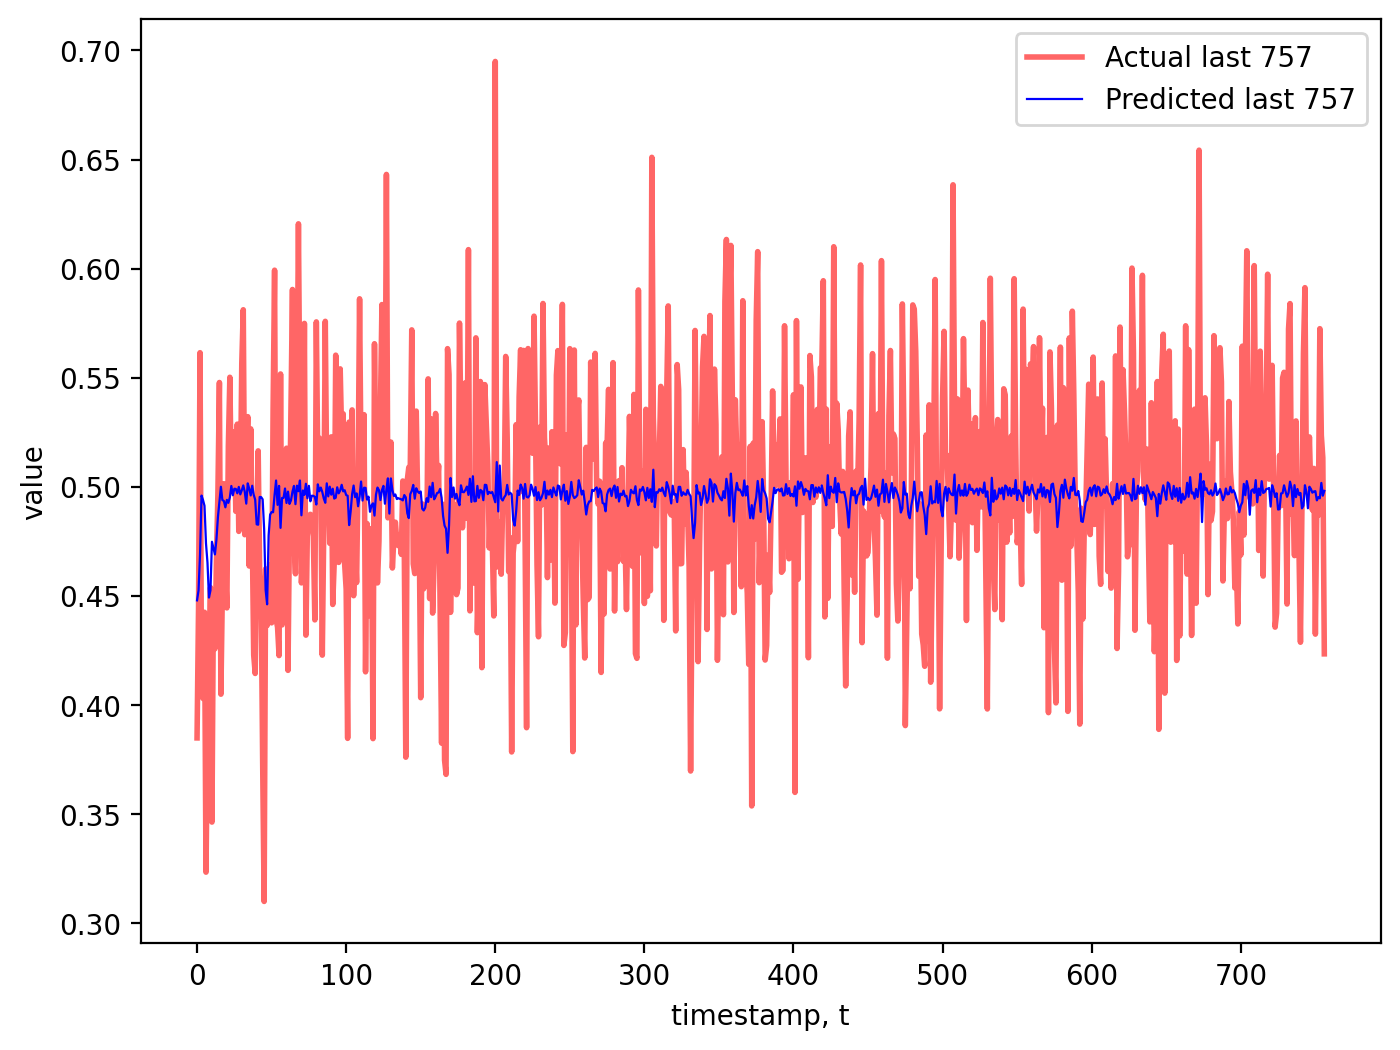

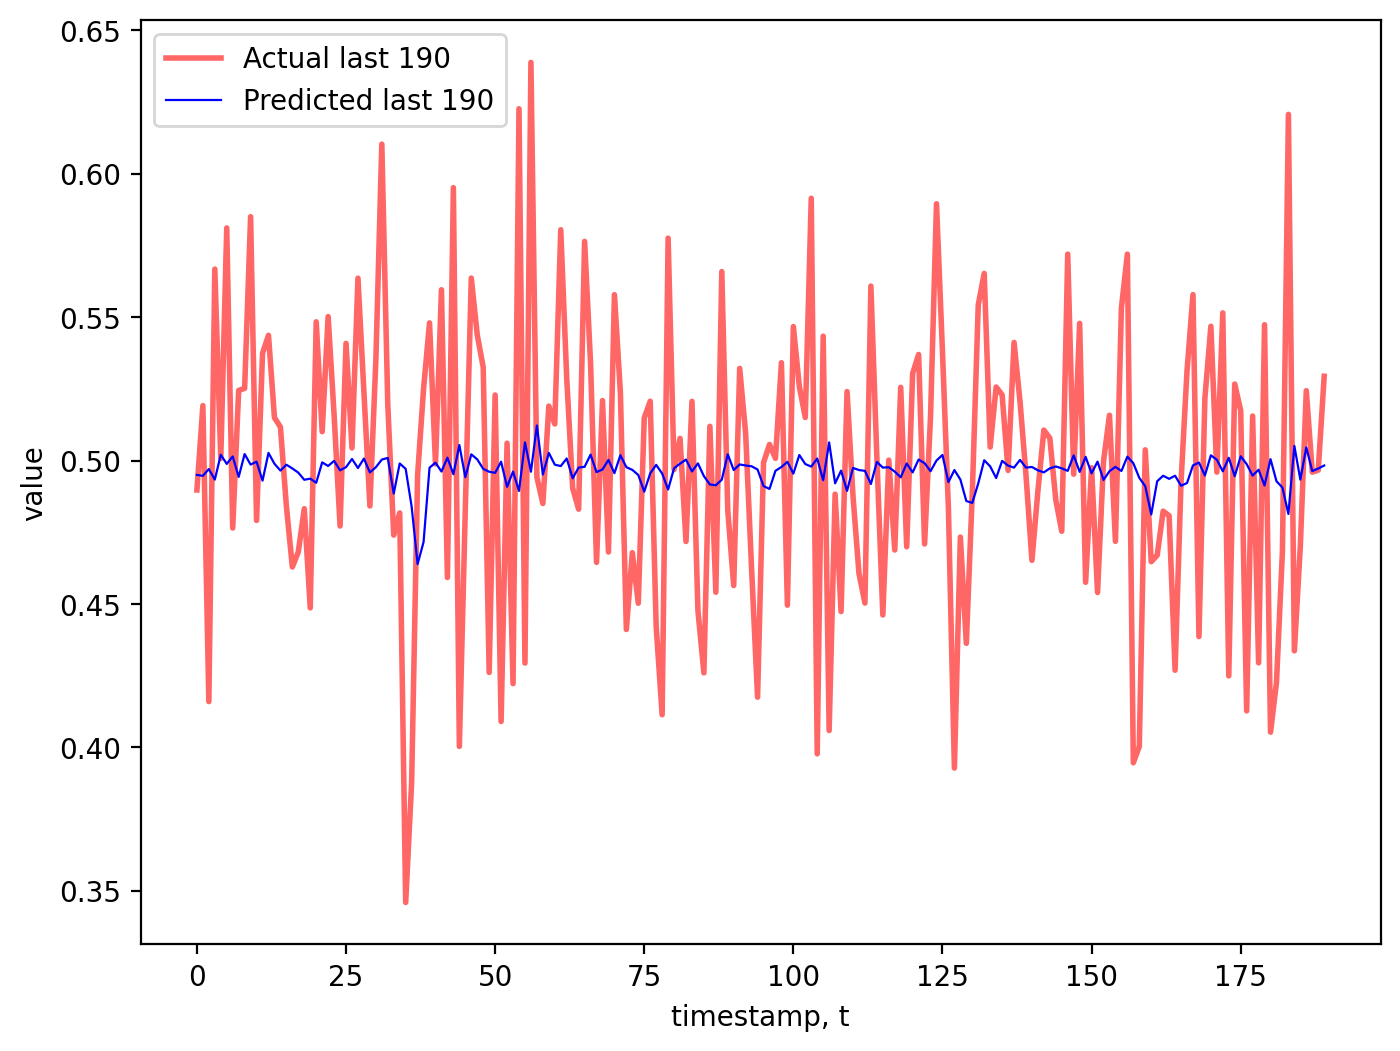

Train data
	rmse: 5.053539219357623 
Test data
	rmse: 5.1270616992705085 


In [ ]:
evaluate_pipeline(SVR(**study.best_trial.params))